In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="6"

import sys
sys.path.append("../")

import mitsuba as mi
import drjit as dr
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d
import numpy as np
import skimage as ski
from helpers.polarization_helpers import *
from helpers.render_helpers import *
from helpers.math_helpers import *

print(mi.variants())
mi.set_variant("cuda_ad_spectral_polarized")

['scalar_rgb', 'scalar_spectral', 'scalar_spectral_polarized', 'llvm_ad_rgb', 'llvm_ad_mono', 'llvm_ad_mono_polarized', 'llvm_ad_spectral', 'llvm_ad_spectral_polarized', 'cuda_ad_rgb', 'cuda_ad_mono', 'cuda_ad_mono_polarized', 'cuda_ad_spectral', 'cuda_ad_spectral_polarized']


In [2]:
scene = mi.load_file("../../scenes/marcus_light_sphere_hair.xml")

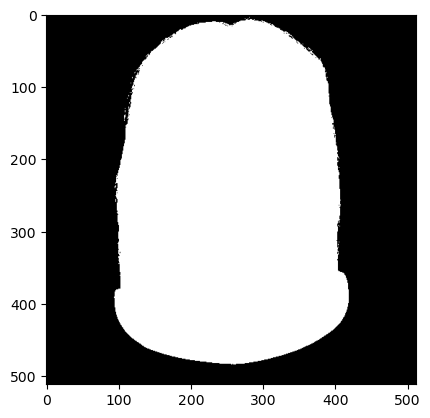

In [11]:
params = mi.traverse(scene)

# Save old transforms
polarizer_light_transform = mi.Transform4f(params["polarizer_light.to_world"])
polarizer_cam_transform = mi.Transform4f(params["polarizer_cam.to_world"])

# Move polarizers away
params["polarizer_light.to_world"] = mi.Transform4f().translate([100, 100, 100])
params["polarizer_cam.to_world"] = mi.Transform4f().translate([100, 100, 100])
params.update()

integrator = mi.load_dict({
	"type": "depth"
})

image = render_from_angle(scene, 75, 0.5 * np.pi, 0, polarized=False, spp=128, integrator=integrator)
image = np.average(image, axis=-1)

threshold = ski.filters.threshold_otsu(image)
mask = np.where(image > image.max() / 2, 0.0, 1.0)

# Undo changes to scenes
params["polarizer_light.to_world"] = polarizer_light_transform
params["polarizer_cam.to_world"] = polarizer_cam_transform
params.update()

plt.imshow(mask.squeeze(), cmap="gray")
# plt.colorbar()
plt.show()

In [ ]:
params = mi.traverse(scene)
print(params["hair.control_points"])
ctrl_points = np.array(params["hair.control_points"]).reshape(4, -1)[:3, :]


[6.80623, 11.1041, -7.66929, .. 19599994 skipped .., -12.5314, -13.3104, 0.004]
(3, 4900000)


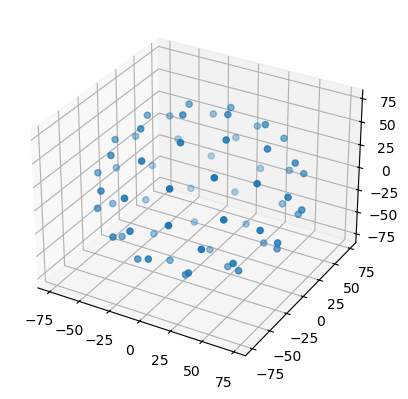

In [2]:
thetas, phis = golden_spiral(64)
positions = spherical_to_cartesian(75, thetas, phis)

x = positions[:, 0]
y = positions[:, 1]
z = positions[:, 2]

plt.figure().add_subplot(111, projection="3d").scatter(x, y, z)
plt.show()

In [6]:
# Train views
thetas_train, phis_train = golden_spiral(64)

# Test views
thetas_0 = np.array([0.35*np.pi, 0.5*np.pi, 0.65*np.pi])
phis_0 = np.linspace(0, 2*np.pi, 4, endpoint=False)

thetas_test, phis_test = np.meshgrid(thetas_0, phis_0)

thetas = np.concatenate([thetas_train, thetas_test.flatten()])
phis = np.concatenate([phis_train, phis_test.flatten()])

print(thetas.shape)
print(phis.shape)

(76,)
(76,)


In [3]:
def to_ski_image(image):
	image[image < 0] = 0

	image = np.array(image ** (1.0 / 2.2))
	image = np.uint8(image * 255.0)
	image = np.clip(image, 0, 255)

	return image

In [2]:
scene = mi.load_file("../../scenes/marcus_light_sphere.xml")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0010533143..1.3650002].


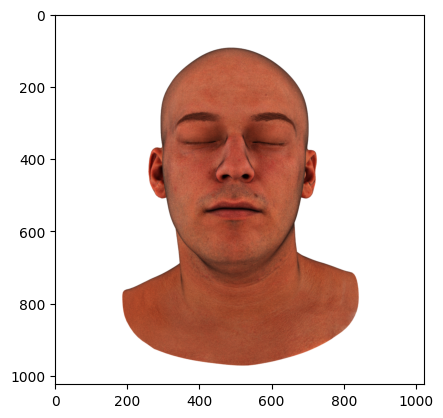

In [ ]:
img_0, img_90 = render_from_angle(scene, 4, np.pi/2, 0)

indirect, direct = separate(img_0, img_90)
reconstruction = reconstruct(indirect, direct)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.044321783..1.1519244].


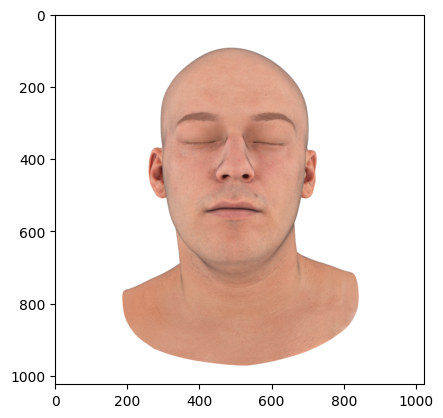

In [4]:

plt.imshow(reconstruction ** (1.0 / 2.2))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0092806965..1.1856097].


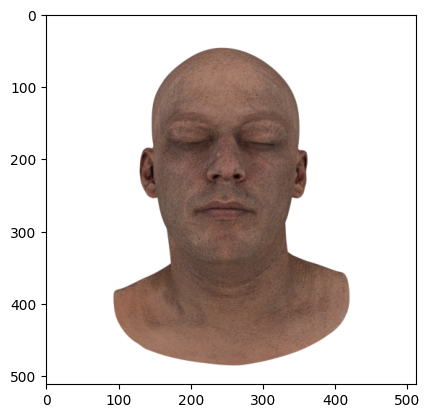

In [8]:
plt.imshow(img_0 ** (1.0 / 2.2))
plt.show()

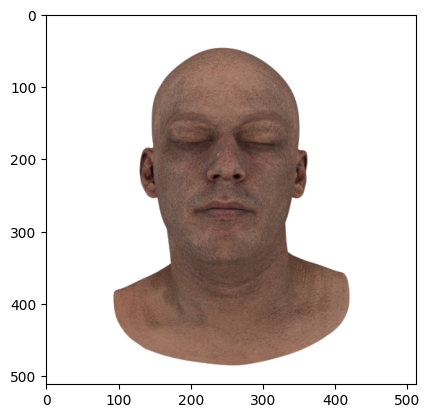

In [18]:
img = img_0.numpy().copy()
img[img < 0] = 0
img = img ** (1.0 / 2.2)
img = np.clip(img, 0, 1)
img = np.uint8(img * 255.0)

plt.imshow(img)
plt.show()

In [8]:
radius = 4
theta = np.pi/2
phi = np.pi

colmap_frame = mi.Frame3f(
	[1, 0, 0],
	[0, -1, 0],
	[0, 0, 1]
)

camera_position = spherical_to_cartesian(radius, theta, phi)
transform = mi.Transform4f().look_at(origin=camera_position, target=[0, 0, 0], up=[0, 1, 0])
view_matrix = transform.matrix.numpy()

print(view_matrix)
print(view_matrix[..., 0])

[[[ 1.0000000e+00]
  [-7.4987995e-33]
  [-1.2246469e-16]
  [ 4.8985874e-16]]

 [[ 0.0000000e+00]
  [ 1.0000000e+00]
  [-6.1232343e-17]
  [ 2.4492937e-16]]

 [[ 1.2246469e-16]
  [ 6.1232343e-17]
  [ 1.0000000e+00]
  [-4.0000000e+00]]

 [[ 0.0000000e+00]
  [ 0.0000000e+00]
  [ 0.0000000e+00]
  [ 1.0000000e+00]]]
[[ 1.0000000e+00 -7.4987995e-33 -1.2246469e-16  4.8985874e-16]
 [ 0.0000000e+00  1.0000000e+00 -6.1232343e-17  2.4492937e-16]
 [ 1.2246469e-16  6.1232343e-17  1.0000000e+00 -4.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]]


In [46]:
params = mi.traverse(scene)
print(params)
print(params["sensor.film.size"])
width, height = params["sensor.film.size"]
print(width)
print(height)
fov = params["sensor.x_fov"][0]
print(fov)

print(params["polarizer_cam.bsdf.polarizing"])

SceneParameters[
  -------------------------------------------------------------------------------------------------------
  Name                                                Flags    Type              Parent
  -------------------------------------------------------------------------------------------------------
  sensor.near_clip                                             float             PerspectiveCamera
  sensor.far_clip                                              float             PerspectiveCamera
  sensor.shutter_open                                          float             PerspectiveCamera
  sensor.shutter_open_time                                     float             PerspectiveCamera
  sensor.film.size                                             ScalarVector2u    HDRFilm
  sensor.film.crop_size                                        ScalarVector2u    HDRFilm
  sensor.film.crop_offset                                      ScalarPoint2u     HDRFilm
  sensor.x_fov      

KeyError: 'polarizer_cam.bsdf.polarizing'

In [4]:
import numpy as np
def fov_to_focal(fov, w):
	return w / (2 * np.tan(np.deg2rad(fov) / 2))

print(fov_to_focal(34, 1024))

1674.67654066388


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..373.25793].


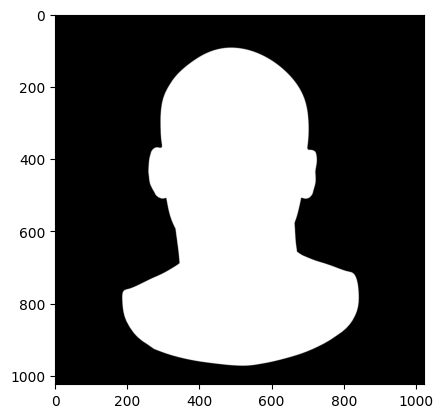

In [6]:
scene = mi.load_file("../../scenes/marcus_mask.xml")
image = mi.render(scene)

plt.imshow(image)
plt.show()

In [4]:
params = mi.traverse(scene)
polarizer_light_transform = mi.Transform4f(params["polarizer_light.to_world"])
polarizer_cam_transform = mi.Transform4f(params["polarizer_cam.to_world"])
params["polarizer_light.to_world"] = mi.Transform4f().translate([100, 100, 100])
params["polarizer_cam.to_world"] = mi.Transform4f().translate([100, 100, 100])
params.update()

positions = np.array(params["head.vertex_positions"]).reshape(-1, 3)
dist = np.linalg.norm(positions, ord=2, axis=1)

cam_transform = params["sensor.to_world"].matrix.numpy()
cam_pos = cam_transform[:3, 3]
cam_dist = np.linalg.norm(cam_pos)

integrator = mi.load_dict({
    "type": "depth"
})

img = mi.render(scene, integrator=integrator).numpy()
img = np.average(img, axis=2)

# background = img > (cam_dist + dist.max())

# mask = np.full_like(img, 1.0)
# mask[background] = 0.0

# plt.imshow(mask, cmap="gray")
# plt.colorbar()
# plt.show()

params["polarizer_light.to_world"] = polarizer_light_transform
params["polarizer_cam.to_world"] = polarizer_cam_transform
params.update()

[(Rectangle[
    to_world = [[-6.12323e-17, 1, 0, 0],
                [1, 6.12323e-17, 0, 0],
                [0, 0, -1, 3.5],
                [0, 0, 0, 1]],
    frame = Frame[
      s=[[-1.22465e-16, 2, 0]],
      t=[[2, 1.22465e-16, 0]],
      n=[[0, 0, -1]]
    ],
    surface_area = [4],
    bsdf = LinearPolarizer[
      theta = UniformSpectrum[value=[0]]
      transmittance = UniformSpectrum[value=[1]]
      polarizing = 1
    ]
  ],
  {'to_world'}),
 (Sphere[
    to_world = [[9, 0, 0, 0],
                [0, 5.51091e-16, -9, 0],
                [0, 9, 5.51091e-16, 0],
                [0, 0, 0, 1]],
    center = [0, 0, 0],
    radius = 9,
    surface_area = [1017.88],
    bsdf = LinearPolarizer[
      theta = UniformSpectrum[value=[90]]
      transmittance = UniformSpectrum[value=[1]]
      polarizing = 1
    ]
  ],
  {'to_world'}),
 (Scene[
    children = [
      PathIntegrator[
        max_depth = 4294967295,
        rr_depth = 5
      ],
      PerspectiveCamera[
        x_fov = 

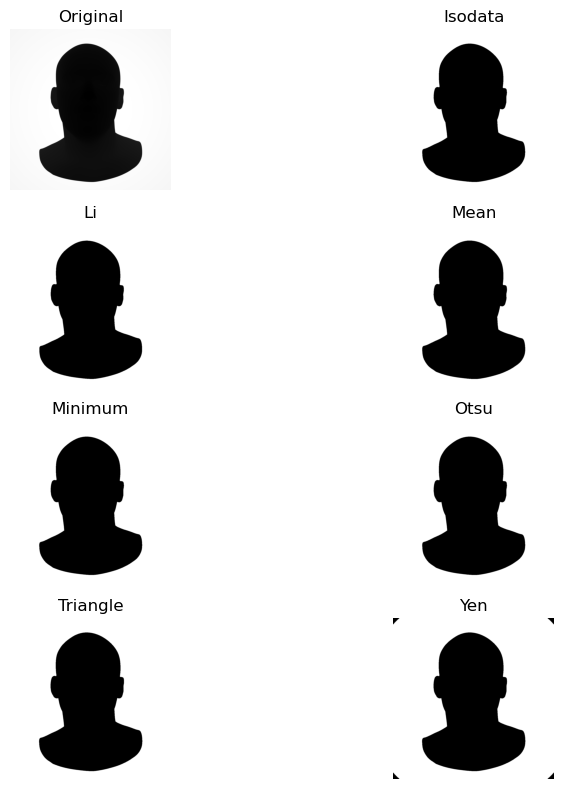

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.079117246..1.8990134].


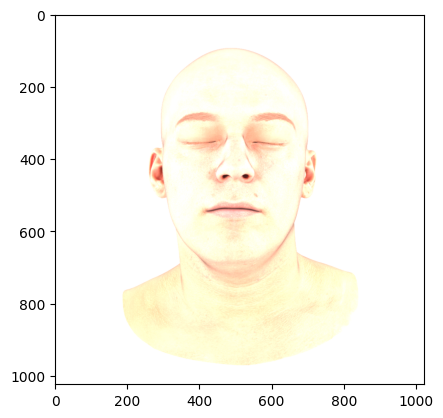

In [4]:
img = mi.render(scene)
plt.imshow(img ** (1.0 / 2.2))
plt.show()

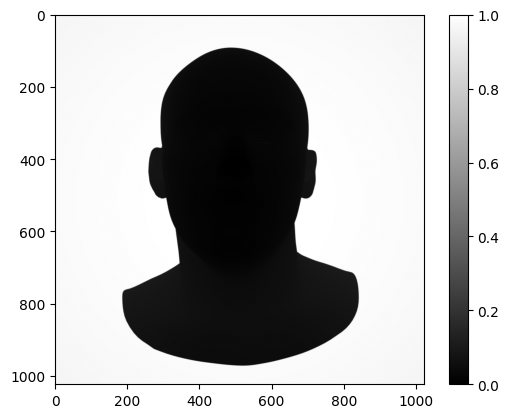

In [16]:
integrator = mi.load_dict({
    "type": "depth"
})

img = mi.render(scene, integrator=integrator).numpy()
img = np.average(img, axis=2)
img = (img - img.min()) / (img.max() - img.min())

plt.imshow(img, cmap="gray")
plt.colorbar()
plt.show()